# Imports



Realiza os imports necessários:

*   Classe Newave do PySDDP: Realiza a leitura do deck do modelo Newave e encapsula todas as informações em um único objeto
*   Importa a biblioteca Numpy com o "apelido" np
* Importa as classes gráficas matplotlib e plotly



In [131]:
## PySDDP

# !pip install PySDDP=='0.0.34'


## Faz o link com a sua conta do Google Drive

# from google.colab import drive
# drive.mount('/content/drive')

In [132]:
from PySDDP.Pen import Newave
import numpy as np
import plotly.graph_objects as go
from matplotlib import pyplot as plt
from random import randint

# Leitura do deck do PMO



Realiza a leitura de um deck do pmo;

Adaptar a variável caminho conforme a pasta em que o deck estiver.

In [133]:
# Caminho = '/content/drive/MyDrive/NewaveJan2021'

Caminho = './NW202308_UNSI_ACL'

Caso = Newave(Caminho)

OK! Leitura do CASO.DAT realizada com sucesso.
OK! Leitura do ARQUIVOS.DAT realizada com sucesso.
OK! Leitura do DGER.DAT realizada com sucesso.
OK! Leitura do HIDR.DAT realizada com sucesso.
OK! Leitura do VAZOES.DAT realizada com sucesso.
OK! Leitura do MODIF.DAT realizada com sucesso. ( 99 Usinas Hidraulicas Modificadas )
OK! Leitura do EXPH.DAT realizada com sucesso. ( 2 Usinas Hidraulicas Expandidas )
OK! Leitura do CONFHD.DAT realizada com sucesso.
OK! Leitura do REE.DAT realizada com sucesso. ( 12 Reservatórios Equivalentes de Energia Foram Lidos )
OK! Leitura do SISTEMA.DAT realizada com sucesso.


# Captura uma UHE



Armazena todas as informações de uma Usina Hidrelétrica (UHE) do deck em um dicionário de dados chamado uhe.

Como o foco do programa será a análise de uma série temporal de vazões, armazena o array contendo as vazões da UHE na variável "vazões".

In [134]:
uhe = Caso.confhd.get('itaipu')

vazoes = uhe['vazoes']

print(vazoes)

[[16387 21639 22979 ...  6669  6784 10683]
 [14288 16700 13753 ...  7644  7130 13757]
 [16743 14271 10964 ...  4660  4133  8014]
 ...
 [12767 11848 10918 ...  8317  7809  7765]
 [12039 14823 11021 ... 10950  8478  9693]
 [17009 18819 19669 ...     0     0     0]]


# Séries Históricas



Plota todas a séries anuais históricas de vazão da UHE;


Em vermelho, média histórica mensal ou MLT (Média de Longo Termo)

Em vermelho pontilhado, média mensal + ou - o desvio padrão mensal.

Em azul, o ano corrente. Como este caso é referente a janeiro de 2021 (somente o mês de janeiro de 2021 possui informação).

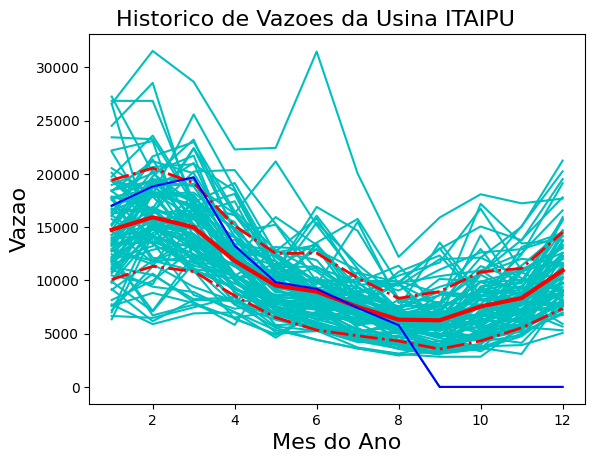

In [135]:
Caso.confhd.plot_vaz(uhe)

# Plota Gráfico de Vazões (Janeiro x Dezembro)

In [136]:
nanos = len(vazoes)
nmes = len(vazoes[0])

janeiros = np.zeros(nanos-2)
dezembros = np.zeros(nanos-2)

for i in range(nanos-2):
  janeiros[i] = vazoes[i+1,0]
  dezembros[i] = vazoes[i,11]

fig = go.Figure()
fig.add_trace(go.Scatter(x=dezembros, y=janeiros, mode='markers'))
fig.update_layout(title='UHE '+uhe['nome'],
                  xaxis_title='Vazão Natural Dezembro (m^3/s)',
                  yaxis_title='Vazão Natural Janeiro (mˆ3/s)')
fig.show()

# Calcula Médias e Desvios Padrões Mensais

In [137]:
nanos = len(vazoes)   # Total de anos menos o primeiro e último

media = np.mean(vazoes[1:(nanos-1)], axis=0)    
desvio = np.std(vazoes[1:(nanos-1)], axis=0)    

print(media)
print(desvio)


[14701.54945055 15832.03296703 14851.76923077 11769.68131868
  9480.56043956  8925.59340659  7506.51648352  6321.25274725
  6310.8021978   7641.24175824  8446.18681319 11059.63736264]
[4702.51027717 4605.28744244 4087.03050824 3267.18516439 3020.31191974
 3646.71854293 2744.25318155 2024.80852218 2651.22225274 3171.25259802
 2674.42167893 3429.57195457]


# Calcula Função de Auto-Correlação

In [138]:
ord_max = 11

# Calcula funcao de auto-correlacao (uma para cada mes)
fac = np.zeros( (12, ord_max+1), 'd')
for ilag in range(ord_max+1):
    for imes in range(12):
        for iano in np.arange(1,nanos-1):
              ano_ant = iano
              mes_ant = imes - ilag
              if mes_ant < 0:
                  ano_ant -= 1
                  mes_ant += 12
              fac[imes][ilag] += (vazoes[iano][imes] - media[imes]) * (vazoes[ano_ant][mes_ant] - media[mes_ant])
        fac[imes][ilag] /= (nanos-2)
        fac[imes][ilag] /= (desvio[imes]*desvio[mes_ant])
print(fac)

[[1.         0.70282587 0.53975504 0.45149596 0.43053133 0.45632794
  0.44644467 0.26202123 0.34673225 0.39973581 0.28310365 0.29356351]
 [1.         0.66722571 0.54149988 0.40802981 0.27746766 0.28345739
  0.36055521 0.3396756  0.17346535 0.28637285 0.2876576  0.20820487]
 [1.         0.67613328 0.45802423 0.44000882 0.35388575 0.23097711
  0.10723314 0.20642272 0.3298844  0.13060901 0.23137655 0.28481906]
 [1.         0.78144619 0.63064043 0.42841823 0.5221968  0.48555729
  0.41881734 0.34106876 0.4675887  0.48758331 0.36535308 0.35810604]
 [1.         0.7071762  0.57311725 0.55423169 0.38444279 0.51114872
  0.43514671 0.3689333  0.33777389 0.49368339 0.50081773 0.3532576 ]
 [1.         0.78184722 0.58024558 0.44597444 0.46675263 0.39164949
  0.50269297 0.4358139  0.3362708  0.26487029 0.44212434 0.5353784 ]
 [1.         0.81594883 0.68713449 0.65782756 0.51028249 0.51543951
  0.40833422 0.48631221 0.37888731 0.31220431 0.26694881 0.45195414]
 [1.         0.74926701 0.66052277 0.6688

# Calcula Função de Auto-Correlação Parcial (FACP)

In [139]:
# Calcula funcao de auto-correlacao parcial (uma para cada mes)
facp = np.zeros((12, ord_max+1), 'd')
for ilag in np.arange(1,ord_max+1):
    for imes in range(12):
        A = np.eye(ilag)
        B = np.zeros(ilag)
        # Preenche matriz triangular superior
        for ilin in range(len(A)):
            for icol in range( len(A) ):           # TODO: Aqui poderia ser np.arange(ilin+1,len(A)): Testar depois
                if icol > ilin:
                    mes = imes - ilin - 1
                    if mes < 0:
                        mes = mes + 12
                    A[ilin][icol] = fac[mes][icol-ilin]
            B[ilin] = fac[imes][ilin+1]
        # Preenche matriz triangular inferior
        for ilin in range(len(A)):
            for icol in range( len(A) ):          # TODO: Aqui poderia ser np.arange(0, ilin): Testar depois
                if icol < ilin:
                    A[ilin][icol] = A[icol][ilin]
        phi = np.linalg.solve(A,B)
        facp[imes][ilag] = phi[ len(phi)-1 ]
print(facp)

[[ 0.          0.70282587  0.03252606  0.04859665  0.05739732  0.19570711
   0.01449011 -0.24055827  0.19563465  0.0990262   0.11980305 -0.14439277]
 [ 0.          0.66722571  0.14338195 -0.01112458 -0.13953854 -0.00119502
   0.19276311 -0.02215193 -0.15374537  0.159001   -0.02804683  0.02997414]
 [ 0.          0.67613328  0.01241997  0.14025058  0.05427219 -0.0374866
  -0.25305572  0.04813367  0.25616994 -0.22594167  0.16256889  0.07920123]
 [ 0.          0.78144619  0.18841268  0.00564573  0.26754687  0.18524946
   0.19575108  0.14793637  0.29323524  0.0210775   0.14164637 -0.16651131]
 [ 0.          0.7071762   0.05264551  0.19110734  0.01838532  0.21798299
   0.00757835  0.03787399  0.05581673  0.34617207  0.11299225 -0.11122746]
 [ 0.          0.78184722  0.0546944  -0.05840148  0.06207573  0.12514265
   0.1019669   0.04050559 -0.07996256 -0.12960976  0.16584538  0.25638132]
 [ 0.          0.81594883  0.12653789  0.30583217  0.0075061   0.07490422
   0.015252   -0.00720943 -0.1176

# Identifica a Ordem P de cada mês

Utiliza os limites de significância na FACP.

In [140]:
# Identificacao da ordem
IC = 1.96/np.sqrt(nanos-1)
ordem = np.zeros(12, 'i')
for imes in range(12):
    ordem[imes] = 0
    for ilag in range(ord_max+1):
        if facp[imes][ilag] > IC or facp[imes][ilag] < -IC:
            ordem[imes] = ilag

# Calcula os coeficientes $\phi$ para cada mês

In [141]:
# Calculo dos coeficientes
coef_parp = np.zeros( (12,ord_max), 'd')
for imes in range(12):
    ilag = ordem[imes]
    A = np.eye(ilag)
    B = np.zeros(ilag)
    # Preenche matriz triangular superior
    for ilin in range(len(A)):
        for icol in range( len(A) ):             # TODO: Aqui poderia ser np.arange(ilin+1,len(A)): Testar depois
            if icol > ilin:
                mes = imes - ilin - 1
                if mes < 0:
                   mes = mes + 12
                A[ilin][icol] = fac[mes][icol-ilin]
        B[ilin] = fac[imes][ilin+1]
    # Preenche matriz triangular inferior
    for ilin in range(len(A)):
        for icol in range( len(A) ):             # TODO: Aqui poderia ser np.arange(0, ilin): Testar depois
            if icol < ilin:
                A[ilin][icol] = A[icol][ilin]
    phi = np.linalg.solve(A,B)
    for iord in range ( len(phi) ):
        coef_parp[imes][iord ] = phi[ iord ]


# Traça FAC e FACP

Colocar na variável mes, o mêês desejado.

0 - Jan, 1 - Fev, ..., 11 Dezembro

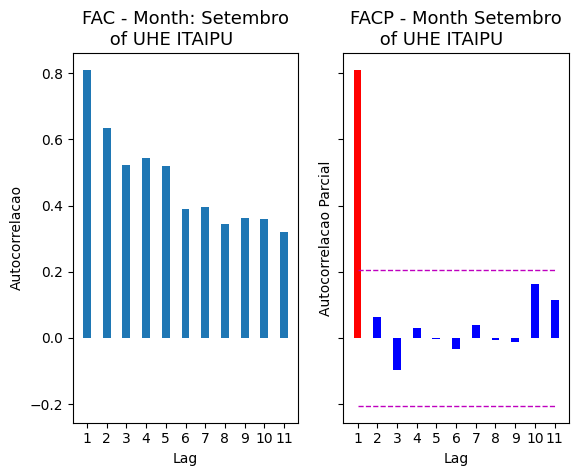

In [142]:
# Escolhe mês para traçar a FAC e FACP (0-Janeiro, ..., 11-Dezembro)
mes = 8

ordmax = ord_max

vazoes = uhe['vazoes']

nanos = len(vazoes) - 1

if mes == 0:
    str_mes = 'January'
elif mes == 1:
    str_mes = 'Fevereiro'
elif mes == 2:
    str_mes = 'Marco'
elif mes == 3:
    str_mes = 'Abril'
elif mes == 4:
    str_mes = 'Maio'
elif mes == 5:
    str_mes = 'Junho'
elif mes == 6:
    str_mes = 'Julho'
elif mes == 7:
    str_mes = 'Agosto'
elif mes == 8:
    str_mes = 'Setembro'
elif mes == 9:
    str_mes = 'Outubro'
elif mes == 10:
    str_mes = 'Novembro'
else:
    str_mes = 'Dezembro'

IC = 1.96/np.sqrt(nanos-1)

cores = []
limitesup = []
limiteinf = []
for elemento in facp[mes][1:ordmax+1]:
    limitesup.append(IC)
    limiteinf.append(-IC)
    if elemento > IC or elemento < -IC:
        cores.append('r')
    else:
        cores.append('b')

f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
barWidth = 0.40

titulo = 'FAC e FACP of ' + str_mes + ' - UHE ' + uhe['nome']
f.canvas.manager.set_window_title(titulo)

ax1.bar(np.arange(1,ordmax+1), fac[mes][1:ordmax+1], barWidth, align='center')
ax2.bar(np.arange(1,ordmax+1), facp[mes][1:ordmax+1], barWidth, align='center', color = cores)
ax2.plot(np.arange(1,ordmax+1), limitesup, 'm--', lw=1)
ax2.plot(np.arange(1,ordmax+1), limiteinf, 'm--', lw=1)

ax1.set_xticks(np.arange(1,ordmax+1))
ax2.set_xticks(np.arange(1,ordmax+1))
tituloFAC =  'FAC - Month: ' + str_mes + '\n of UHE ' + uhe['nome']
tituloFACP = 'FACP - Month ' + str_mes +  '\n of UHE ' + uhe['nome']
ax1.set_title(tituloFAC,  fontsize = 13)
ax2.set_title(tituloFACP, fontsize =13)
ax1.set_xlabel('Lag')
ax2.set_xlabel('Lag')
ax1.set_ylabel('Autocorrelacao')
ax2.set_ylabel('Autocorrelacao Parcial')

plt.show()

# Função parp do PySDDP

In [143]:
Caso.confhd.parp(uhe,11)

(array([ 7,  1,  9,  8,  9, 11,  3,  3,  1,  6,  9,  9], dtype=int32),
 array([[ 0.62376482,  0.00835041, -0.00322342, -0.09426498,  0.22730958,
          0.19310377, -0.24055827,  0.        ,  0.        ,  0.        ,
          0.        ],
        [ 0.66722571,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        ],
        [ 0.62423301, -0.08990638,  0.11857451,  0.04913142,  0.10971578,
         -0.30406995, -0.05947804,  0.42399106, -0.22594167,  0.        ,
          0.        ],
        [ 0.64221177,  0.14827244, -0.20976754,  0.12209504,  0.02132724,
          0.08252008, -0.05408648,  0.29323524,  0.        ,  0.        ,
          0.        ],
        [ 0.40779652,  0.0724465 ,  0.16954608, -0.16782738,  0.25095762,
         -0.04841479, -0.01136005, -0.16684361,  0.34617207,  0.        ,
          0.        ],
        [ 0.65857145,  0.07216328, -0.1522899 ,  0.03228638,  0.04417921,


# Função plota_parp do PySDDP

In [144]:
# Caso.confhd.plota_parp(uhe, 1, 11)

# Cálculo dos Resíduos Normalizados

In [145]:
residuos = np.zeros( (nanos-1, 12) )
for iano in np.arange(1,nanos-1):
    for imes in range(12):
        residuos[iano][imes]= ( vazoes[iano][imes]-media[imes] ) / desvio[imes]
        for ilag in range(ord_max):
            ano_ant = iano
            mes_ant = imes - ilag - 1
            if mes_ant < 0:
                ano_ant -= 1
                mes_ant += 12
            residuos[iano][imes] -= coef_parp[imes][ilag]*(vazoes[ano_ant][mes_ant]-media[mes_ant])/desvio[mes_ant]
print(residuos)

[[ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.13462827  0.24714919 -0.19321171 ...  0.32470004 -0.49083318
   1.19716755]
 [ 0.00973012 -0.62862094 -0.85727038 ... -0.17035859 -0.9053974
   0.20267773]
 ...
 [-0.97082605 -0.74445585  1.00857744 ... -0.72269097 -0.20796027
   1.00532325]
 [-0.68809944  0.47680781 -0.02945263 ... -0.7288093  -0.50162102
  -0.16600223]
 [ 0.229824   -0.59061206 -0.25402133 ...  1.17149901 -0.21071618
  -0.47122457]]


# Plota Nuvem de Cenários Sintéticos

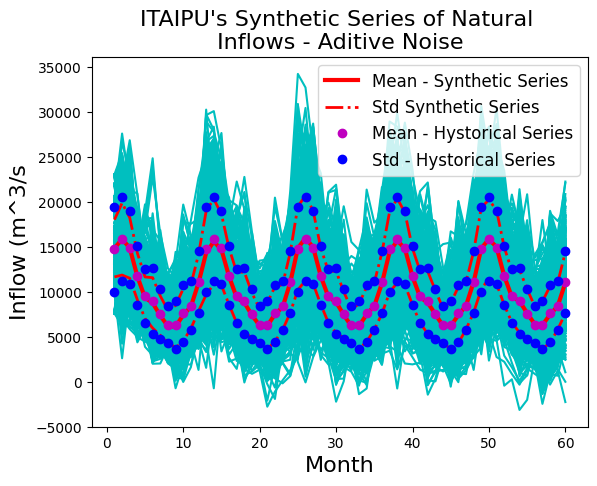

In [146]:
nr_cen = 1000

#
# Pega Parâmetros Básicos
#
nanos_estudo = len(uhe['status_vol_morto'])
nmeses_estudo = len(uhe['status_vol_morto'][0])
nestagios = nanos_estudo*nmeses_estudo
vazoes = uhe['vazoes']
nanos = len(vazoes) - 1
media = np.mean(vazoes[1:(nanos-1)], 0)    # A primeira serie historica eh utilizada como tendencia (despreze-a)
desvio = np.std(vazoes[1:(nanos-1)], 0)    # A primeira serie historica eh utilizada como tendencia (despreze-a)

# Gera series sinteticas
sintetica_adit = np.zeros((nr_cen,nestagios),'d')
for iser in range(nr_cen):
    contador = -1
    for iano in range(nanos_estudo):
        for imes in range(nmeses_estudo):
            contador += 1
            serie = randint(1,nanos-2)
            valor = media[imes] + desvio[imes]*residuos[serie][imes]
            for ilag in range(ord_max):
                mes_ant = imes - ilag - 1
                ano_ant = iano
                if mes_ant < 0:
                    mes_ant += 12
                    ano_ant -= 1
                if ano_ant < 0:
                    vazant = media[mes_ant]
                else:
                    vazant = sintetica_adit[iser][contador-1-ilag]
                valor += desvio[imes]*coef_parp[imes][ilag]*(vazant-media[mes_ant])/desvio[mes_ant]
            sintetica_adit[iser][contador] = valor

x_axis = np.arange(1, nestagios+1)
plt.plot(x_axis, sintetica_adit.transpose(), 'c-')
plt.plot(x_axis, np.mean(sintetica_adit,0), 'r-', lw=3, label='Mean - Synthetic Series')
plt.plot(x_axis, np.mean(sintetica_adit,0) + np.nanstd(sintetica_adit, axis=0), 'r-.', lw=2, label='Std Synthetic Series')
plt.plot(x_axis, np.mean(sintetica_adit,0) - np.nanstd(sintetica_adit, axis=0), 'r-.', lw=2)
m = np.concatenate([ media, media, media, media, media])
d = np.concatenate([ desvio, desvio, desvio, desvio, desvio])
plt.plot(x_axis, m, 'mo', lw=3, label='Mean - Hystorical Series')
plt.plot(x_axis, m + d, 'bo', lw=2, label='Std - Hystorical Series')
plt.plot(x_axis, m - d, 'bo', lw=2)
titulo = uhe['nome'].strip() + "'s Synthetic Series of Natural \n" " Inflows - Aditive Noise "
plt.title(titulo, fontsize=16)
plt.xlabel('Month', fontsize=16)
plt.ylabel('Inflow (m^3/s', fontsize=16)
plt.legend(fontsize=12)
plt.show()


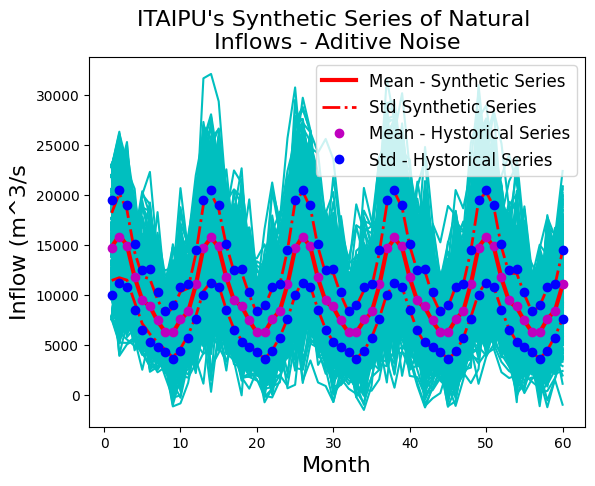

In [147]:
sinteticos = Caso.confhd.gera_cen_sinteticos(uhe, 11, 1000)

In [148]:
print(np.shape(sinteticos))

(1000, 60)
